# Modo Vdc/Q en el simulador RMS VSC-HVDC

En este notebook vamos a:

- Trabajar con un escenario en el que el control regula **Vdc** y **Q**.
- Ajustar la referencia de tensión DC `Vdc_ref` y la referencia de potencia reactiva `Q_ref`.
- Ejecutar varias simulaciones con distintos valores de `Vdc_ref`.
- Visualizar la respuesta de `Vdc` y `Q_ac` en el tiempo.

> Nota: usamos únicamente la API pública `run_simulation`  
> y los ficheros JSON de `../tests/data/`. No modificamos el modelo ni la ingeniería.


In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt

from vscsim.api.simulation import run_simulation
from vscsim.utils.logger import configure_global_logger_from_config


In [2]:
def load_json(path: Path) -> dict:
    with path.open("r", encoding="utf-8") as f:
        return json.load(f)

# Rutas relativas desde notebooks/ hacia tests/data/
params_path = Path("../tests/data/params.json")
scenario_path = Path("../tests/data/scenario.json")

params_base = load_json(params_path)
scenario_base = load_json(scenario_path)

list(params_base.keys()), list(scenario_base.keys())


(['L', 'R', 'Cdc', 'omega', 'V_max', 'Kp_id', 'Kp_iq'],
 ['control_mode',
  'P_ref',
  'Q_ref',
  'v_pcc_d',
  'v_pcc_q',
  'initial_conditions'])

## Referencias Vdc_ref y Q_ref

En esta demo asumiremos que las referencias de control se implementan
mediante algunas de las siguientes claves (o similares):

- `Vdc_ref` (referencia de tensión en el enlace DC)
- `Q_ref`   (referencia de potencia reactiva)

Dependiendo de cómo estén definidos los JSON del proyecto, estas referencias
pueden estar en:

- `params_config` (parámetros de control), o
- `scenario_config` (definición del escenario).

Para mantener el notebook robusto, el helper buscará esas claves en ambos
diccionarios y solo las modificará si existen.


In [3]:
def run_vdcq_case(
    Vdc_ref: float,
    Q_ref: float,
    t_end: float = 0.5,
    dt: float = 1e-3,
) -> dict:
    """
    Ejecuta una simulación con referencias Vdc_ref y Q_ref constantes.
    No altera params_base ni scenario_base originales.
    """
    # Copias independientes
    params_config = dict(params_base)
    scenario_config = dict(scenario_base)

    # No meter strings en params_config (el loader convierte a float)
    # Limpieza defensiva por si hubiera quedado algo raro en el estado del kernel
    for k in ("nr_norm", "nr_verbose"):
        v = params_config.get(k)
        if isinstance(v, str):
            params_config.pop(k, None)

    # --- Aplicar referencias Vdc_ref y Q_ref si existen las claves ---

    # Vdc_ref: primero intentamos en params, luego en scenario
    if "Vdc_ref" in params_config:
        params_config["Vdc_ref"] = float(Vdc_ref)
    elif "Vdc_ref" in scenario_config:
        scenario_config["Vdc_ref"] = float(Vdc_ref)
    else:
        print("⚠ Aviso: no se encontró clave 'Vdc_ref' ni en params ni en scenario.")

    # Q_ref
    if "Q_ref" in params_config:
        params_config["Q_ref"] = float(Q_ref)
    elif "Q_ref" in scenario_config:
        scenario_config["Q_ref"] = float(Q_ref)
    else:
        print("⚠ Aviso: no se encontró clave 'Q_ref' ni en params ni en scenario.")

    # Logging
    configure_global_logger_from_config({"log_level": "warning", "log_json": False})

    results = run_simulation(
        params_config=params_config,
        scenario_config=scenario_config,
        t_end=t_end,
        dt=dt,
    )
    return results


In [4]:
Vdc_ref = 1.0   # en pu (ajusta según tu modelo)
Q_ref = 0.0     # mantén Q ≈ 0 como punto base

results_vdcq = run_vdcq_case(Vdc_ref=Vdc_ref, Q_ref=Q_ref, t_end=0.5, dt=1e-3)

time = results_vdcq["time"]
x_hist = results_vdcq["x"]   # dict: clave -> lista de valores (formato columnar)
y_hist = results_vdcq["y"]

Vdc_series = x_hist.get("Vdc", [])
Q_series = y_hist.get("Q_ac", [])

len(time), len(Vdc_series), len(Q_series)


⚠ Aviso: no se encontró clave 'Vdc_ref' ni en params ni en scenario.


(501, 501, 501)

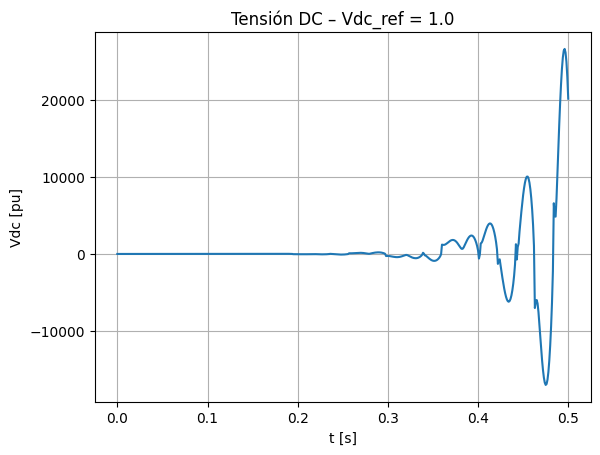

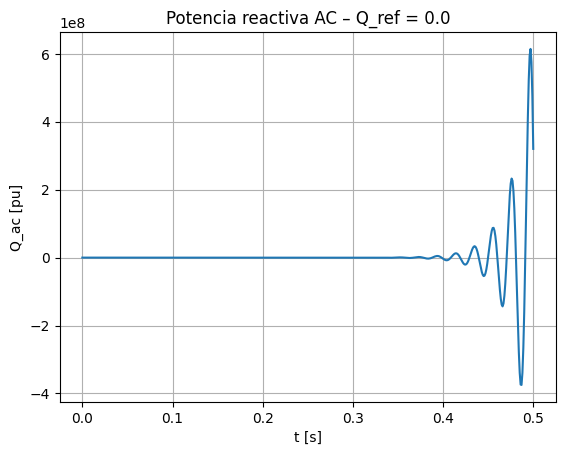

In [5]:
plt.figure()
plt.plot(time, Vdc_series)
plt.xlabel("t [s]")
plt.ylabel("Vdc [pu]")
plt.title(f"Tensión DC – Vdc_ref = {Vdc_ref}")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(time, Q_series)
plt.xlabel("t [s]")
plt.ylabel("Q_ac [pu]")
plt.title(f"Potencia reactiva AC – Q_ref = {Q_ref}")
plt.grid(True)
plt.show()


## Barrido de Vdc_ref con Q_ref fijo

Ahora vamos a:

- Fijar `Q_ref = 0.0`.
- Ejecutar varios casos con:

  - `Vdc_ref = 0.95`
  - `Vdc_ref = 1.00`
  - `Vdc_ref = 1.05`

y superponer las curvas de `Vdc(t)` y `Q_ac(t)` para ver cómo responde
el convertidor.


⚠ Aviso: no se encontró clave 'Vdc_ref' ni en params ni en scenario.
⚠ Aviso: no se encontró clave 'Vdc_ref' ni en params ni en scenario.
⚠ Aviso: no se encontró clave 'Vdc_ref' ni en params ni en scenario.


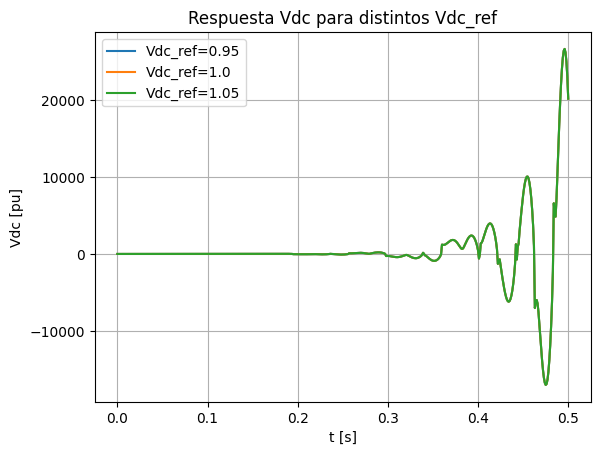

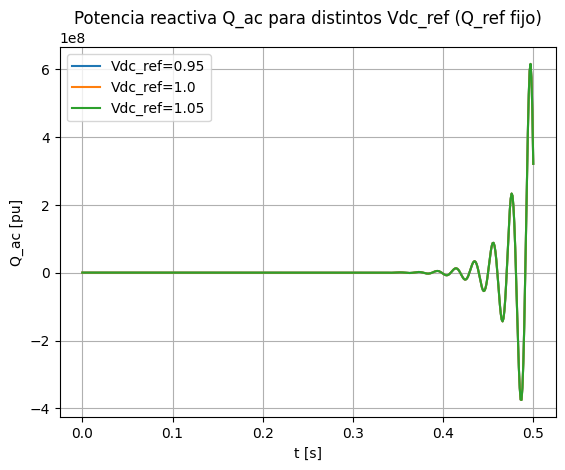

In [6]:
Vdc_refs = [0.95, 1.0, 1.05]
Q_ref = 0.0
t_end = 0.5
dt = 1e-3

all_results_vdc = {}

for Vref in Vdc_refs:
    res = run_vdcq_case(Vdc_ref=Vref, Q_ref=Q_ref, t_end=t_end, dt=dt)
    all_results_vdc[Vref] = res

plt.figure()
for Vref, res in all_results_vdc.items():
    t = res["time"]
    Vdc_series = res["x"].get("Vdc", [])
    plt.plot(t, Vdc_series, label=f"Vdc_ref={Vref}")
plt.xlabel("t [s]")
plt.ylabel("Vdc [pu]")
plt.title("Respuesta Vdc para distintos Vdc_ref")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
for Vref, res in all_results_vdc.items():
    t = res["time"]
    Q_series = res["y"].get("Q_ac", [])
    plt.plot(t, Q_series, label=f"Vdc_ref={Vref}")
plt.xlabel("t [s]")
plt.ylabel("Q_ac [pu]")
plt.title("Potencia reactiva Q_ac para distintos Vdc_ref (Q_ref fijo)")
plt.grid(True)
plt.legend()
plt.show()


## Resumen

En este notebook hemos visto:

- Cómo reutilizar los archivos `params.json` y `scenario.json`.
- Cómo construir un helper `run_vdcq_case` que:
  - copia `params_config` y `scenario_config`,
  - aplica referencias `Vdc_ref` y `Q_ref` solo si las claves existen,
  - llama a `vscsim.api.simulation.run_simulation`.
- Cómo visualizar la respuesta de:
  - la tensión DC `Vdc(t)`,
  - la potencia reactiva `Q_ac(t)`,
  para distintos valores de `Vdc_ref`.

Este notebook, junto con:
- `01_introduccion_simulador.ipynb`
- `02_modo_PQ.ipynb`

completa la parte básica de modos de operación P/Q y Vdc/Q del simulador.
